In [83]:
from GA import solve
from TSP import compute_distance_matrix, visualize
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [84]:

file_path = '../data/5_CentralRegion.csv'

In [85]:
locations = pd.read_csv(file_path, header=None).values
locations


array([['province', 'lat', 'lon'],
       ['Thanh Hóa', '19.9781573', '105.4816107'],
       ['Nghệ An', '19.1976001', '105.0606760'],
       ['Hà Tĩnh', '18.3504832', '105.7623047'],
       ['Quảng Bình', '17.5095990', '106.4004452'],
       ['Quảng Trị', '16.7897806', '106.9797431'],
       ['Thừa Thiên Huế', '16.4639321', '107.5863388'],
       ['Quảng Nam', '15.5761698', '108.0527132'],
       ['Quảng Ngãi', '14.9953739', '108.6917290'],
       ['Bình Định', '14.0779378', '108.9898798'],
       ['Phú Yên', '13.1912633', '109.1273678'],
       ['Khánh Hòa', '12.2980751', '108.9950386'],
       ['Ninh Thuận', '11.6965639', '108.8928476'],
       ['Bình Thuận', '11.1041572', '108.1832931'],
       ['Kon Tum', '14.6995372', '107.9323831'],
       ['Gia Lai', '13.8177445', '108.2004015'],
       ['Đắk Lắk', '12.8292274', '108.2999058'],
       ['Đắk Nông', '12.2818851', '107.7302484'],
       ['Lâm Đồng', '11.6614957', '108.1335279'],
       ['Đà Nẵng', '16.0680000', '108.2120000']], dt

In [86]:
locations_numeric = locations[1:, 1:].astype(float)
distance_matrix = compute_distance_matrix(locations_numeric)

In [87]:
def analyze_single_parameter(param_name, param_values, base_config, distance_matrix):
    """Phân tích tác động của một tham số"""
    results = []
    fitness_histories = []
    
    print(f"\nAnalyzing {param_name}...")
    print("-" * 50)
    
    for value in param_values:
        config = base_config.copy()
        config[param_name] = value
        
        print(f"Running with {param_name} = {value}")
        
        best_distance, best_route, fitness_history = solve(
            distance_matrix,
            population_size=config.get('population_size', 100),
            generations=config.get('generations', 200),
            mutation_rate=config.get('mutation_rate', 0.01),
            mutation_algorithm=config.get('mutation_algorithm', 'swap'),
            crossover_algorithm=config.get('crossover_algorithm', 'single_point'),
            selection_algorithm=config.get('selection_algorithm', 'tournament')
        )
        
        results.append({
            'best_distance': best_distance,
            'best_route': best_route,
            'fitness_history': fitness_history,
            'config': config
        })
        fitness_histories.append(fitness_history)
        
        print(f"  Best distance: {best_distance:.2f} km")
    
    return results, fitness_histories

In [88]:
best_result = min(results, key=lambda x: x['best_distance'])
# In kết quả của cấu hình tốt nhất (giả sử là kết quả đầu tiên)
print("Best route:", best_result['best_route'])
print("Total distance (km):", best_result['best_distance'])

Best route: [1, 2, 3, 4, 5, 6, 19, 7, 8, 9, 10, 11, 12, 13, 18, 17, 16, 15, 14, 1]
Total distance (km): 2300.6335582883025


In [89]:
base_config = {
    'population_size': 100,
    'generations': 200,
    'mutation_rate': 0.01,
    'mutation_algorithm': 'swap',
    'crossover_algorithm': 'single_point',
    'selection_algorithm': 'tournament'
}

In [90]:
# Thêm phân tích Solution Quality và Convergence Speed
def analyze_performance(fitness_data, labels, title):
    """Phân tích chất lượng lời giải và tốc độ hội tụ"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Solution Quality (Best Final Distance)
    final_distances = [fitness[-1] for fitness in fitness_data]
    bars1 = ax1.bar(labels, final_distances, color=['skyblue', 'orange', 'lightgreen'])
    ax1.set_ylabel('Best Distance (km)')
    ax1.set_title(f'Solution Quality - {title}')
    ax1.grid(True, alpha=0.3)
    
    # Thêm giá trị lên cột
    for bar, val in zip(bars1, final_distances):
        ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:.1f}', 
                ha='center', va='bottom')
    
    # Convergence Speed (Generation to reach 95% of final improvement)
    convergence_speeds = []
    for fitness in fitness_data:
        initial = fitness[0]
        final = fitness[-1]
        target = initial - 0.95 * (initial - final)
        
        conv_gen = len(fitness) - 1  # Default to last generation
        for i, f in enumerate(fitness):
            if f <= target:
                conv_gen = i
                break
        convergence_speeds.append(conv_gen)
    
    bars2 = ax2.bar(labels, convergence_speeds, color=['skyblue', 'orange', 'lightgreen'])
    ax2.set_ylabel('Convergence Generation')
    ax2.set_title(f'Convergence Speed - {title}')
    ax2.grid(True, alpha=0.3)
    
    # Thêm giá trị lên cột
    for bar, val in zip(bars2, convergence_speeds):
        ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [91]:
def analyze_parameter_combinations(configs, distance_matrix):
    # Phân tích các tổ hợp tham số
    results = []
    fitness_histories = []
    
    print("\nAnalyzing parameter combinations...")
    print("-" * 50)
    
    for i, config in enumerate(configs):
        print(f"Running configuration {i+1}/{len(configs)}: {config}")
        
        best_distance, best_route, fitness_history = solve(
            distance_matrix,
            population_size=config.get('population_size', 100),
            generations=config.get('generations', 200),
            mutation_rate=config.get('mutation_rate', 0.01),
            mutation_algorithm=config.get('mutation_algorithm', 'swap'),
            crossover_algorithm=config.get('crossover_algorithm', 'single_point'),
            selection_algorithm=config.get('selection_algorithm', 'tournament')
        )
        
        results.append({
            'best_distance': best_distance,
            'best_route': best_route,
            'fitness_history': fitness_history,
            'config': config
        })
        fitness_histories.append(fitness_history)
        
        print(f"  Best distance: {best_distance:.2f} km")
    
    return results, fitness_histories

### Ảnh hưởng của Population size


Analyzing population_size...
--------------------------------------------------
Running with population_size = 100


  Best distance: 2392.11 km
Running with population_size = 500
  Best distance: 2469.03 km
Running with population_size = 1000
  Best distance: 2469.03 km


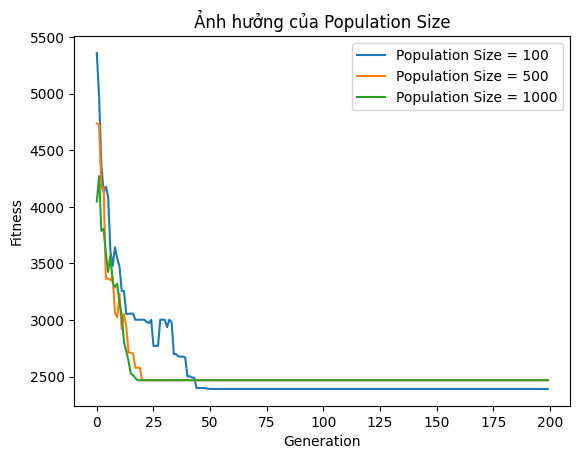

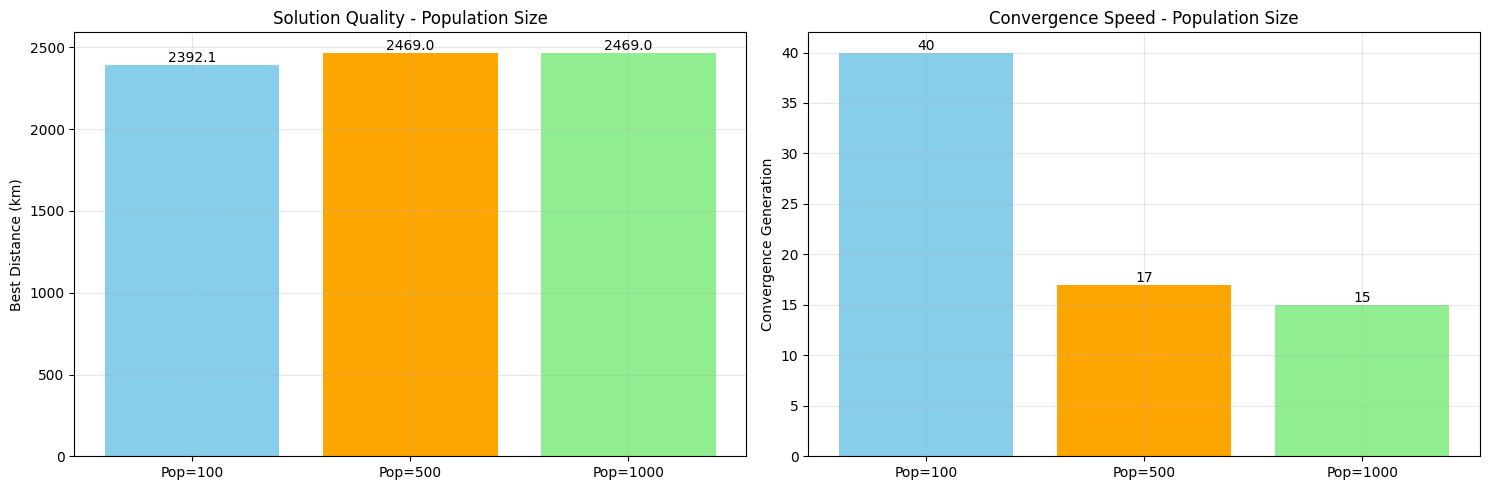

In [92]:
# Ảnh hưởng của Population size
population_sizes = [100, 500, 1000]
pop_results, pop_fitness = analyze_single_parameter('population_size', population_sizes, base_config, distance_matrix)

# Lấy fitness histories (giống như fitness1, fitness2, fitness3 cũ)
fitness1, fitness2, fitness3 = pop_fitness

plt.plot(fitness1, label='Population Size = 100')
plt.plot(fitness2, label='Population Size = 500')
plt.plot(fitness3, label='Population Size = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Population Size")
plt.legend()
plt.show()

# Phân tích Solution Quality và Convergence Speed (từ Box trước)
analyze_performance([fitness1, fitness2, fitness3], 
                   ['Pop=100', 'Pop=500', 'Pop=1000'], 
                   'Population Size')


### Đánh giá kết quả:

Xu hướng chung
- Tất cả ba kịch bản đều cho thấy fitness giảm dần theo thời gian và cuối cùng ổn định ở mức khoảng 2500. Điều này cho thấy quần thể đang tiến hóa hướng tới một trạng thái cân bằng.

Tác động của kích thước quần thể
- Population Size = 100 (đường xanh dương):
    - Biến động mạnh nhất, đặc biệt trong 40 thế hệ đầu
    - Có nhiều dao động ngẫu nhiên do kích thước nhỏ
    - Mất khoảng 40 thế hệ để ổn định
- Population Size = 500 (đường cam):
    - Giảm nhanh và ổn định hơn so với quần thể 100
    - Ít biến động hơn, đường cong mượt mà hơn
    - Đạt ổn định sớm hơn, khoảng 17 thế hệ
- Population Size = 1000 (đường xanh lá):
    - Giảm nhanh nhất và ổn định sớm nhất
    - Đường cong mượt mà nhất, ít nhiễu
    - Đạt trạng thái ổn định sau khoảng 15 thế hệ

Kết luận: Kích thước quần thể lớn hơn dẫn đến:

- Quá trình tiến hóa ổn định và dự đoán được hơn
- Giảm thiểu tác động của yếu tố ngẫu nhiên (genetic drift)
- Hội tụ nhanh hơn về trạng thái tối ưu
- Hiệu quả tìm kiếm giải pháp tốt hơn

Điều này phù hợp với lý thuyết tiến hóa, khi quần thể lớn có đa dạng di truyền cao hơn và ít bị ảnh hưởng bởi các yếu tố ngẫu nhiên.




Analyzing mutation_rate...
--------------------------------------------------
Running with mutation_rate = 0.01
  Best distance: 2392.11 km
Running with mutation_rate = 0.05
  Best distance: 2515.02 km
Running with mutation_rate = 0.1
  Best distance: 3551.14 km


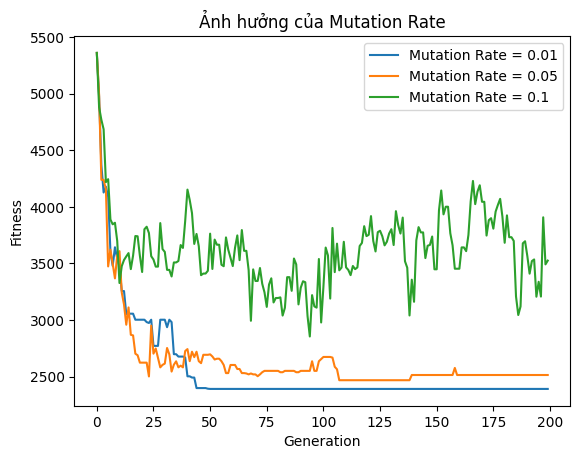

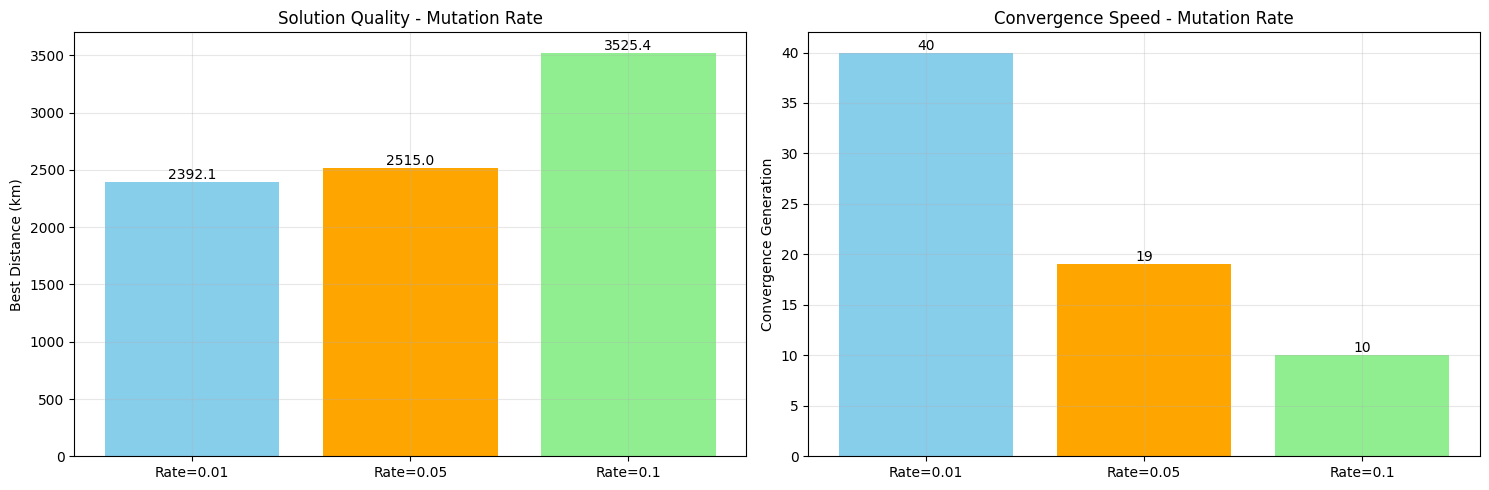

In [93]:
# Ảnh hưởng của mutation_rate
mutation_rates = [0.01, 0.05, 0.1]
mut_results, mut_fitness = analyze_single_parameter('mutation_rate', mutation_rates, base_config, distance_matrix)

# Lấy fitness histories (fitness1 đã có từ trước, chỉ cần fitness4, fitness5)
fitness1, fitness4, fitness5 = mut_fitness

plt.plot(fitness1, label='Mutation Rate = 0.01')
plt.plot(fitness4, label='Mutation Rate = 0.05')
plt.plot(fitness5, label='Mutation Rate = 0.1')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Mutation Rate")
plt.legend()
plt.show()

# Phân tích Solution Quality và Convergence Speed
analyze_performance([fitness1, fitness4, fitness5], 
                   ['Rate=0.01', 'Rate=0.05', 'Rate=0.1'], 
                   'Mutation Rate')

### Đánh giá kết quả:

Mutation Rate = 0.01 (đường cam):

- Có xu hướng hội tụ nhanh nhất trong giai đoạn đầu
- Đạt được fitness tốt (khoảng 2500) và ổn định sau thế hệ thứ 50
- Cho thấy sự ổn định cao nhưng có thể bị kẹt ở local optimum

Mutation Rate = 0.05 (đường xanh dương):

- Hội tụ chậm hơn so với 0.01
- Fitness dao động nhiều hơn trong suốt quá trình tiến hóa
- Cuối cùng cũng đạt được mức fitness tương tự (khoảng 2500)

Mutation Rate = 0.1 (đường xanh lá):

- Dao động mạnh nhất trong suốt quá trình
- Fitness không ổn định, liên tục biến động
- Cho thấy khả năng khám phá không gian tìm kiếm tốt nhưng khó hội tụ

Kết luận và đánh giá:
- Ưu điểm của mutation rate thấp (0.01):

    - Hội tụ nhanh và ổn định
    - Phù hợp khi cần kết quả nhanh và đáng tin cậy
- Nhược điểm của mutation rate thấp (0.01):

    - Có thể bị kẹt ở local optimum
    - Ít khả năng thoát khỏi các điểm tối ưu cục bộ

- Mutation rate cao (0.1):

    - Duy trì tính đa dạng tốt
    - Khả năng khám phá không gian tìm kiếm cao
    - Nhưng khó đạt được sự ổn định
    
- Kết luận: 
    - Trong trường hợp này, mutation rate = 0.01 cho kết quả tốt nhất với sự cân bằng giữa tốc độ hội tụ và chất lượng nghiệm. 
    - Tuy nhiên, có thể cần kết hợp với các kỹ thuật khác để tránh local optimum.


## Ảnh hưởng của generations


Analyzing generations...
--------------------------------------------------
Running with generations = 100
  Best distance: 2392.11 km
Running with generations = 500
  Best distance: 2392.11 km
Running with generations = 1000
  Best distance: 2392.11 km


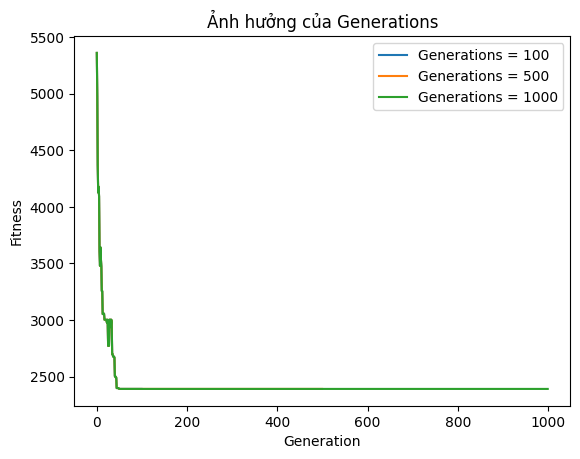

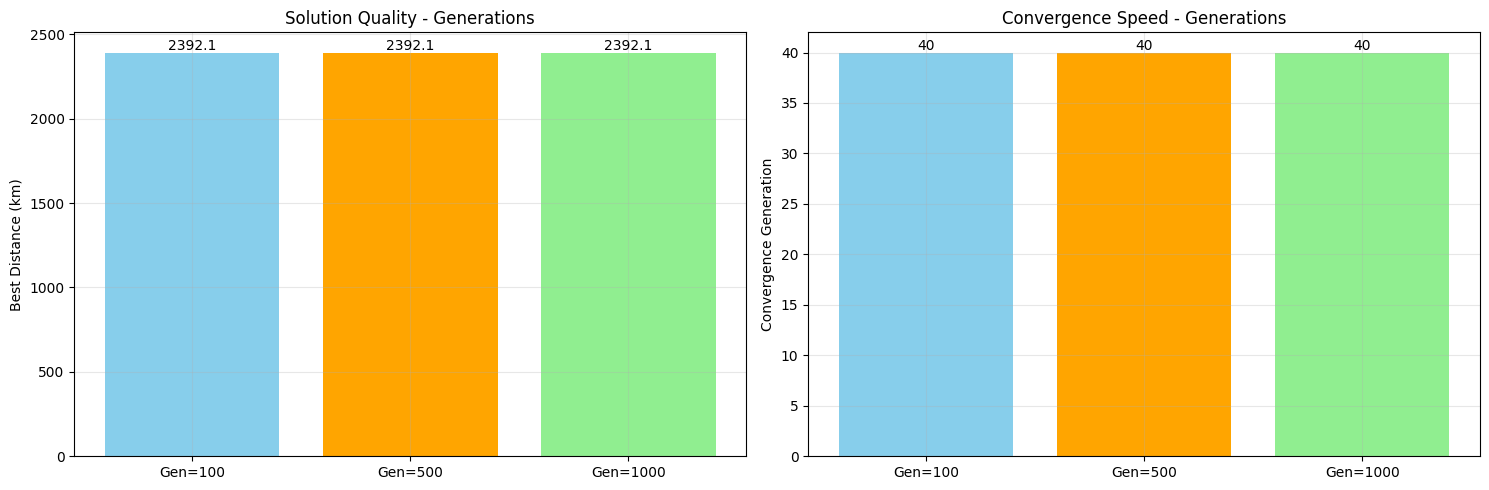

In [94]:
# Ảnh hưởng của generations
generations_list = [100, 500, 1000]
gen_results, gen_fitness = analyze_single_parameter('generations', generations_list, base_config, distance_matrix)

# Lấy fitness histories
fitness1, fitness2, fitness3 = gen_fitness

plt.plot(fitness1, label='Generations = 100')
plt.plot(fitness2, label='Generations = 500')
plt.plot(fitness3, label='Generations = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Generations")
plt.legend()
plt.show()

# Phân tích Solution Quality và Convergence Speed
analyze_performance([fitness1, fitness2, fitness3], 
                   ['Gen=100', 'Gen=500', 'Gen=1000'], 
                   'Generations')

### Đánh giá kết quả:

- Gen = 100 : Dừng sớm nhất nhưng vẫn đạt được kết quả khá tốt, phù hợp khi quan tâm đến tốc độ hội tụ.
- Gen = 500, 1000 : Cho kết quả tối ưu hoá tốt hơn, đường cong fitness trở nên tương đối phẳng, cho thấy thuật toán đã tìm được vùng tối ưu địa phương và khó cải thiện thêm.
- Cần xem xét các kỹ thuật khác như điều chỉnh tham số đột biến, lai ghép, hoặc thuật toán hybrid để thoát khỏi tối ưu địa phương
- Việc tăng số thế hệ tuy làm tăng chi phí tính toán nhưng không mang lại nhiều lợi ích trong trường hợp này, vì phần lớn sự cải thiện đã xảy ra ở các thế hệ ban đầu.

## Tăng đồng thời mutation_rate và population_size


Analyzing parameter combinations...
--------------------------------------------------
Running configuration 1/3: {'generations': 50, 'mutation_rate': 0.1, 'population_size': 500}
  Best distance: 3118.33 km
Running configuration 2/3: {'generations': 50, 'mutation_rate': 0.05, 'population_size': 1000}
  Best distance: 2500.26 km
Running configuration 3/3: {'generations': 50, 'mutation_rate': 0.1, 'population_size': 1000}
  Best distance: 3064.93 km


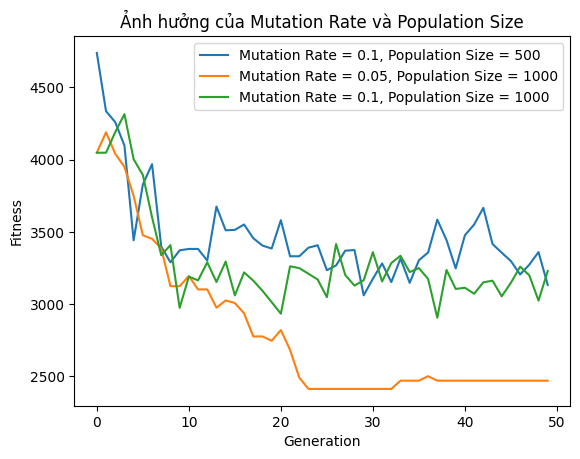

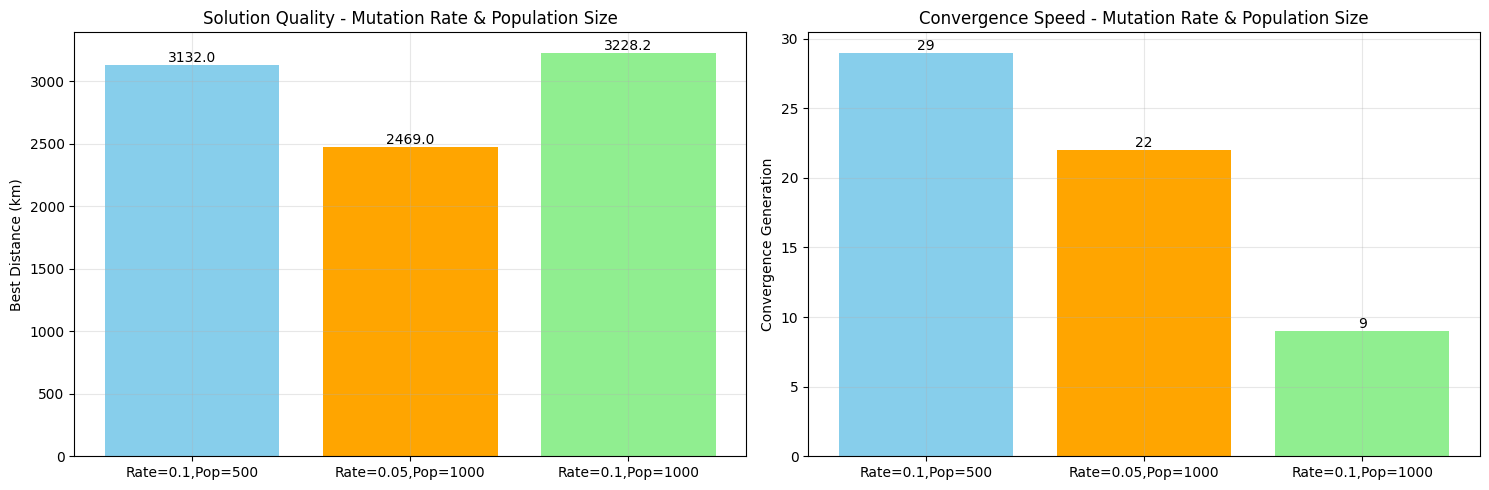

In [98]:
combination_configs_1 = [
    {'generations': 50, 'mutation_rate': 0.1, 'population_size': 500},
    {'generations': 50, 'mutation_rate': 0.05, 'population_size': 1000},
    {'generations': 50, 'mutation_rate': 0.1, 'population_size': 1000}
]

combo_results_1, combo_fitness_1 = analyze_parameter_combinations(combination_configs_1, distance_matrix)
fitness1, fitness2, fitness3 = combo_fitness_1

plt.plot(fitness1, label='Mutation Rate = 0.1, Population Size = 500')
plt.plot(fitness2, label='Mutation Rate = 0.05, Population Size = 1000')
plt.plot(fitness3, label='Mutation Rate = 0.1, Population Size = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Mutation Rate và Population Size")
plt.legend()
plt.show()

analyze_performance([fitness1, fitness2, fitness3], 
                   ['Rate=0.1,Pop=500', 'Rate=0.05,Pop=1000', 'Rate=0.1,Pop=1000'], 
                   'Mutation Rate & Population Size')


### Đánh giá kết quả:

- Đường xanh dương (Mut = 0.1, Pop = 500): Hiệu quả kém nhất. Đường xanh dao động mạnh và hội tụ chậm, fitness vẫn còn cao (> 3000) sau 50 thế hệ. Population nhỏ làm giảm đa dạng, dẫn đến hội tụ kém.
- Đường cam (Mut = 0.05, Pop = 1000): Đây là cấu hình có hiệu quả tốt nhất. Đường cam giảm nhanh chóng và ổn định ở mức fitness thấp nhất (~2400), chứng tỏ thuật toán hội tụ sớm và ổn định.
- Đường xanh lá (Mut = 0.1, Pop = 1000): Hiệu suất trung bình. Mặc dù fitness giảm nhanh ban đầu, nhưng không đạt đến mức thấp như đường cam. Có dấu hiệu dao động nhẹ, cho thấy mức đột biến cao có thể gây nhiễu.

Kết luận :

- Tăng Population Size (500 → 1000) giúp cải thiện hiệu quả rõ rệt nhờ tăng đa dạng quần thể.
- Giảm Mutation Rate (0.1 → 0.05) có lợi trong trường hợp Population Size đủ lớn, giúp thuật toán hội tụ mượt hơn và ít dao động.
- Cấu hình tốt nhất trong thử nghiệm: Đường cam (Mut = 0.05, Pop = 1000)

## Tăng đồng thời mutation_rate và generations


Analyzing parameter combinations...
--------------------------------------------------
Running configuration 1/3: {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100}
  Best distance: 2392.11 km
Running configuration 2/3: {'generations': 100, 'mutation_rate': 0.05, 'population_size': 100}
  Best distance: 2674.54 km
Running configuration 3/3: {'generations': 50, 'mutation_rate': 0.1, 'population_size': 100}
  Best distance: 3763.58 km


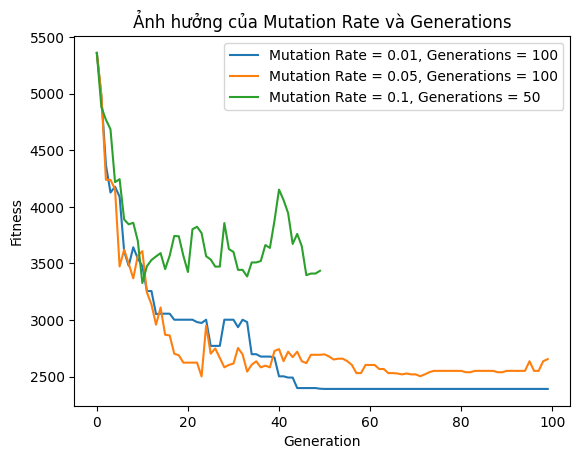

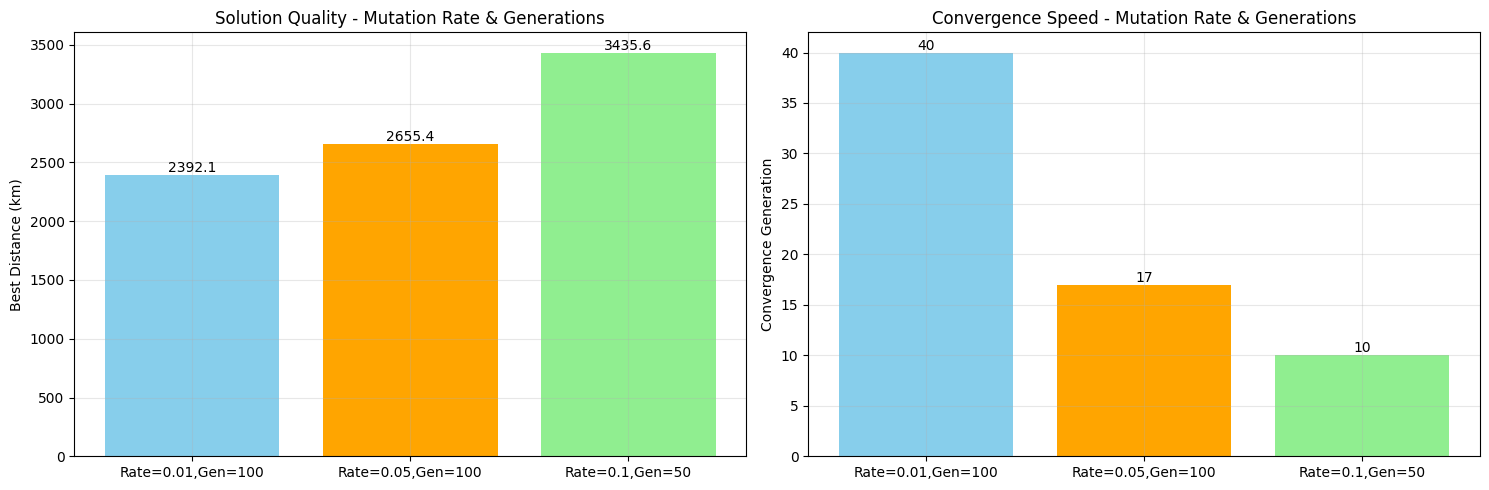

In [101]:
combination_configs_2 = [
    {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100},
    {'generations': 100, 'mutation_rate': 0.05, 'population_size': 100},
    {'generations': 50, 'mutation_rate': 0.1, 'population_size': 100}
]

combo_results_2, combo_fitness_2 = analyze_parameter_combinations(combination_configs_2, distance_matrix)
fitness1, fitness2, fitness3 = combo_fitness_2

plt.plot(fitness1, label='Mutation Rate = 0.01, Generations = 100')
plt.plot(fitness2, label='Mutation Rate = 0.05, Generations = 100')
plt.plot(fitness3, label='Mutation Rate = 0.1, Generations = 50')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Mutation Rate và Generations")
plt.legend()
plt.show()

analyze_performance([fitness1, fitness2, fitness3], 
                   ['Rate=0.01,Gen=100', 'Rate=0.05,Gen=100', 'Rate=0.1,Gen=50'], 
                   'Mutation Rate & Generations')

### Đánh giá kết quả:

- Đường xanh dương (Mut = 0.01, Gen = 100): Hiệu quả cao nhất trong thí nghiệm. Đường hội tụ đều đặn và ổn định về mức fitness thấp nhất (~2400). Tỷ lệ đột biến thấp kết hợp với số thế hệ lớn giúp thuật toán khai thác tốt không gian tìm kiếm và tránh bị nhiễu. 
- Đường cam (Mut = 0.05, Gen = 100): Cũng đạt hiệu quả tốt, hội tụ nhanh về mức fitness thấp (~2500). Tuy nhiên, vẫn dao động nhẹ hơn so với đường xanh dương do tỷ lệ đột biến cao hơn, có thể gây ra thay đổi ngẫu nhiên lớn hơn trong quần thể. 
- Đường xanh lá (Mut = 0.1, Gen = 50): Hiệu quả kém nhất. Fitness giảm chậm và dao động nhiều, không đạt được mức hội tụ tốt do số thế hệ thấp và tỷ lệ đột biến cao, dẫn đến quá trình tiến hóa bị nhiễu và không đủ thời gian để cải thiện lời giải.   

Kết luận : 
- Đường xanh dương (Mut = 0.01, Gen = 100) mang lại hiệu quả tối ưu. Cấu hình này giúp thuật toán hội tụ chậm nhưng chắc chắn, đạt được lời giải chất lượng cao với độ ổn định rõ rệt. 
- Đường cam (Mut = 0.05, Gen = 100), thuật toán vẫn giữ được hiệu quả tốt, mặc dù có phần dao động hơn. Điều này cho thấy trong điều kiện số thế hệ đủ lớn, mức đột biến vừa phải vẫn có thể duy trì hiệu quả hội tụ. 
- Ngược lại, Đường xanh lá (Mut = 0.1, Gen = 50), kết quả trở nên kém ổn định. Thuật toán không có đủ thời gian để tối ưu lời giải, và mức đột biến cao làm giảm chất lượng quá trình tiến hóa.

## Tăng đồng thời generations và population_size


Analyzing parameter combinations...
--------------------------------------------------
Running configuration 1/3: {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100}
  Best distance: 2392.11 km
Running configuration 2/3: {'generations': 500, 'mutation_rate': 0.01, 'population_size': 500}
  Best distance: 2469.03 km
Running configuration 3/3: {'generations': 1000, 'mutation_rate': 0.01, 'population_size': 1000}
  Best distance: 2469.03 km


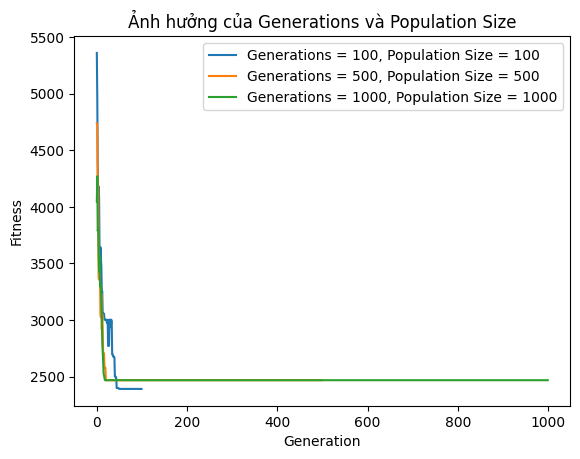

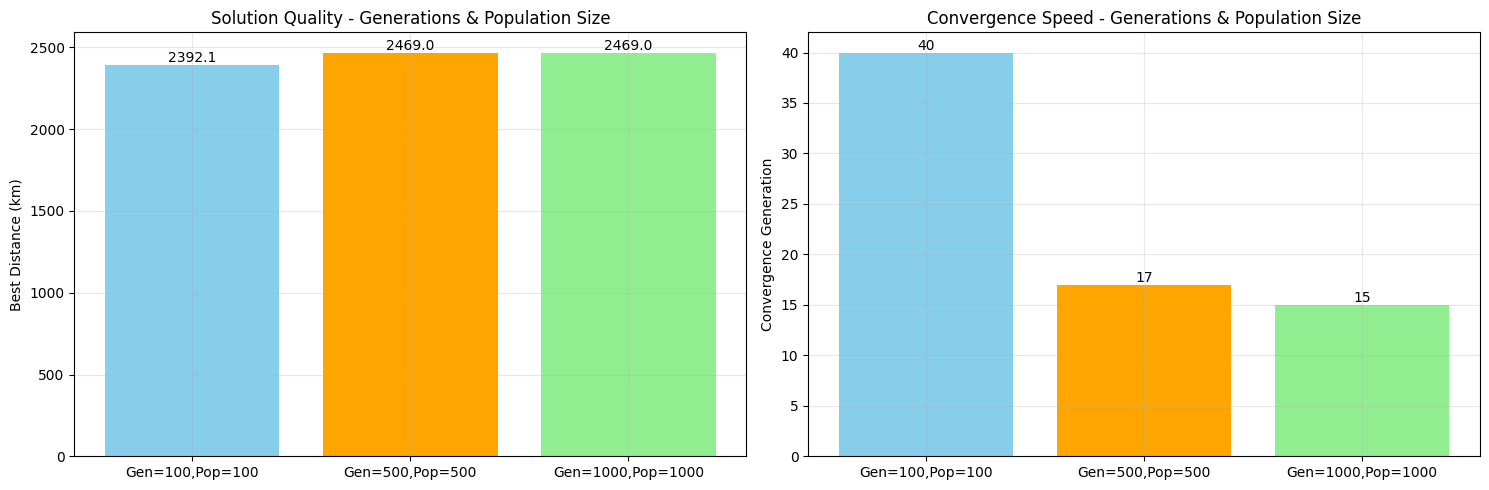

In [97]:
combination_configs_3 = [
    {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100},
    {'generations': 500, 'mutation_rate': 0.01, 'population_size': 500},
    {'generations': 1000, 'mutation_rate': 0.01, 'population_size': 1000}
]

combo_results_3, combo_fitness_3 = analyze_parameter_combinations(combination_configs_3, distance_matrix)
fitness1, fitness2, fitness3 = combo_fitness_3

plt.plot(fitness1, label='Generations = 100, Population Size = 100')
plt.plot(fitness2, label='Generations = 500, Population Size = 500')
plt.plot(fitness3, label='Generations = 1000, Population Size = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Generations và Population Size")
plt.legend()
plt.show()

analyze_performance([fitness1, fitness2, fitness3], 
                   ['Gen=100,Pop=100', 'Gen=500,Pop=500', 'Gen=1000,Pop=1000'], 
                   'Generations & Population Size')

### Đánh giá kết quả:

- Màu xanh dương (Gen = 1000, Pop = 1000): Fitness ban đầu cao (~4200), duy trì ổn định ở mức cao nhất (~2500)
- Màu cam (Gen = 500, Pop = 500): Fitness ban đầu trung bình (~3000), giảm và ổn định ở ~2400
- Màu xanh lá (Gen = 100, Pop = 100): Fitness cao nhất ban đầu (~5400) nhưng giảm nhanh và ổn định ở mức thấp (~2400)

Kết luận: 

- Quần thể lớn (1000) cho kết quả ổn định và fitness cuối cùng cao nhất
-  Thuật toán hội tụ nhanh, không lãng phí tài nguyên tính toán, nhưng đồng thời cũng có nguy cơ mắc kẹt tại local optimum (điển hình khi fitness không cải thiện sau đó).
- Có thể cần điều chỉnh các tham số khác (mutation rate, selection pressure) để tránh hội tụ sớm